# Segmentação de órgãos e estruturas fetais em exames ultrassonográficos



## Descrição:

Para esta aplicação foi utilizado o dataset presente [neste link](https://data.mendeley.com/datasets/4gcpm9dsc3/1), com por volta de 1500 imagens coletadas de 169 participantes que contribuíram com um número váriavel de imagens da circunferência do abdômen fetal (CA). As participantes elegíveis foram gestantes com idade igual ou superior a 18 anos, em trabalho de parto ou com parto programado na Maternidade do Hospital Universitário Polydoro Ernani de São Thiago, em Florianópolis, Santa Catarina, Brasil. 

Médicos especialistas usaram um protocolo de aquisição padronizado para obter imagens de ultrassom. Uma seção axial comum da CA fetal foi capturada, com medidas tomadas na parte mais larga do abdômen fetal, abrangendo o fígado. Esta seção abrangeu o estômago fetal, a artéria aorta, a coluna vertebral e a porção intra-hepática da veia umbilical.

As imagens  de ultrassom foram adquiridas usando uma variedade de dispositivos de ultrassom. Para o processo de anotação, foi empregado o software 3D Slicer para marcar e identificar cuidadosamente cada região de interesse e condição, como esteatose hepática e desequilíbrio metabólico. Depois que as imagens e anotações ficaram prontas, converteu-se as imagens de ultrassom para o formato PNG para facilitar a manipulação e análise. As anotações foram exportadas do 3D Slicer e salvas no formato .npy. Dentro de cada arquivo .npy, é incluído um dicionário que mapeia as estruturas anotadas para suas respectivas imagens. 

### Inicializações:

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from sklearn.metrics import precision_score,recall_score
import pandas as pd
from modelo import load,evaluate,Model,ORGAOS, colors,clean,create_reshape,transform,reduce, remove_black, conf_matrix
from plot import img_with_labels, plot_pred
import seaborn as sns

In [2]:
def plot_images(data_ex, title, with_labels=False):
    print(title)
    plt.figure(figsize=(30, 30))
    for i in range(len(data_ex)):
        plt.subplot(5, 5, i + 1)
        img, structures = data_ex[i]
        if with_labels:
            img = img_with_labels(img, structures)
        plt.imshow(img, 'gray' if not with_labels else None)
        plt.axis("off")
    
    if with_labels:
        legend_patches = [mpatches.Patch(color=color, label=label) for label, color in zip(ORGAOS, [cor/255 for cor in list(colors.values())])]
        plt.legend(handles=legend_patches, loc='upper left', fontsize=10, bbox_to_anchor=(1.1, 1))
    
    plt.show()

### Visão geral do dataset:

1588 Imagens no total.

Exemplos de imagens cruas:


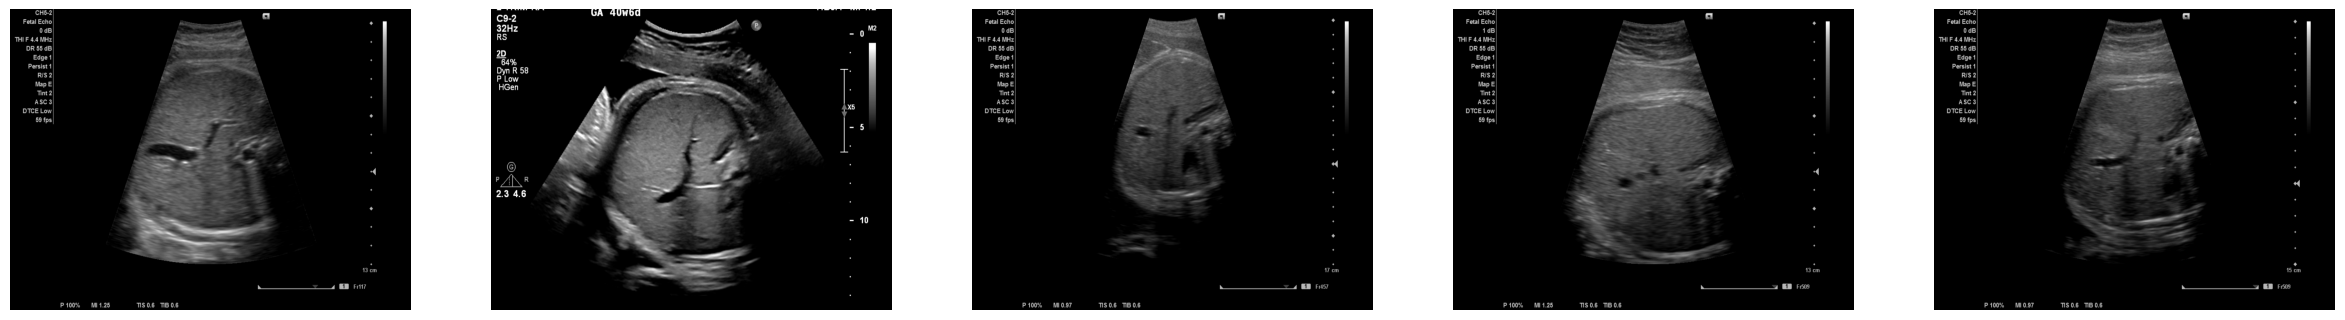

Exemplos de imagens com as anotações:


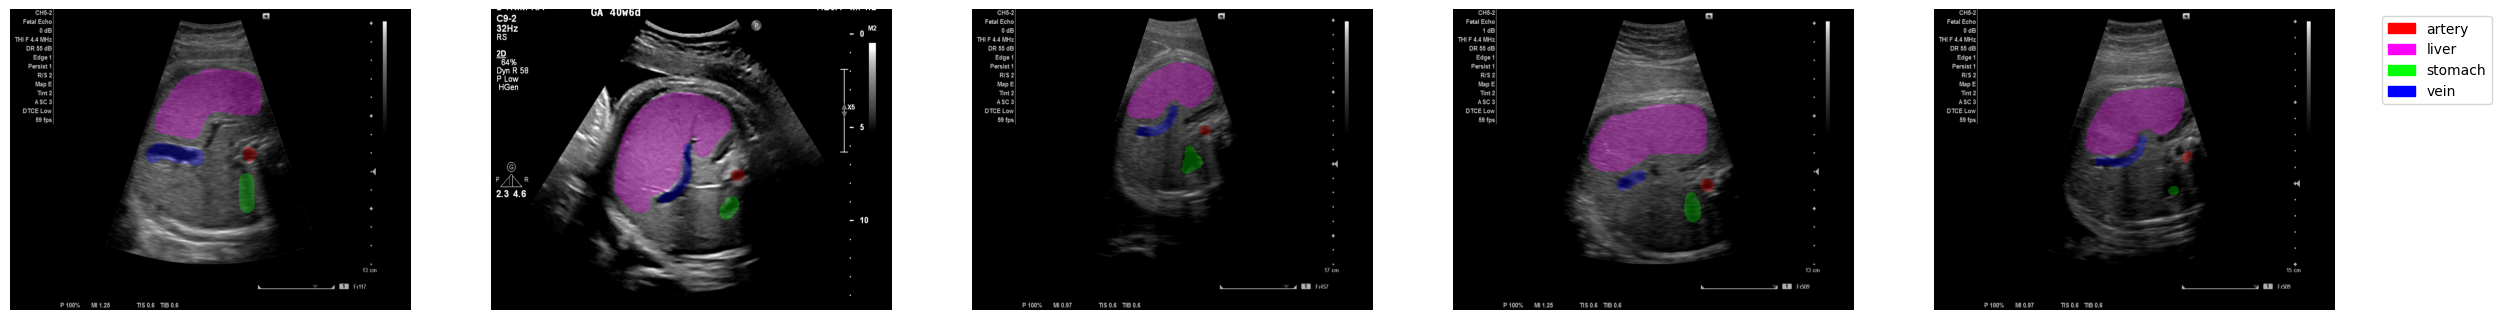

In [3]:
folder = 'ARRAY_FORMAT'
data_files = [os.path.join(folder,name) for name in os.listdir(folder)]
print(f"{len(data_files)} Imagens no total.\n")

data_ex = []
for i in range(5):
    img, structures = load(data_files[i])
    data_ex.append((img, structures))


plot_images(data_ex, "Exemplos de imagens cruas:")

plot_images(data_ex, "Exemplos de imagens com as anotações:", with_labels=True)



### Pipeline de processamento:



**Passo 1**: Limpeza das imagens usando utilizando operações morfológicas de erosão e dilatação para processar a máscara e escolher a maior região conectada da imagem.

**Passo 2**: Para padronizar as imagens é feito o reshape.

**Passo 3**: É feita também a remoção das bordas da imagens e retirado o fundo preto.

Imagens limpas:


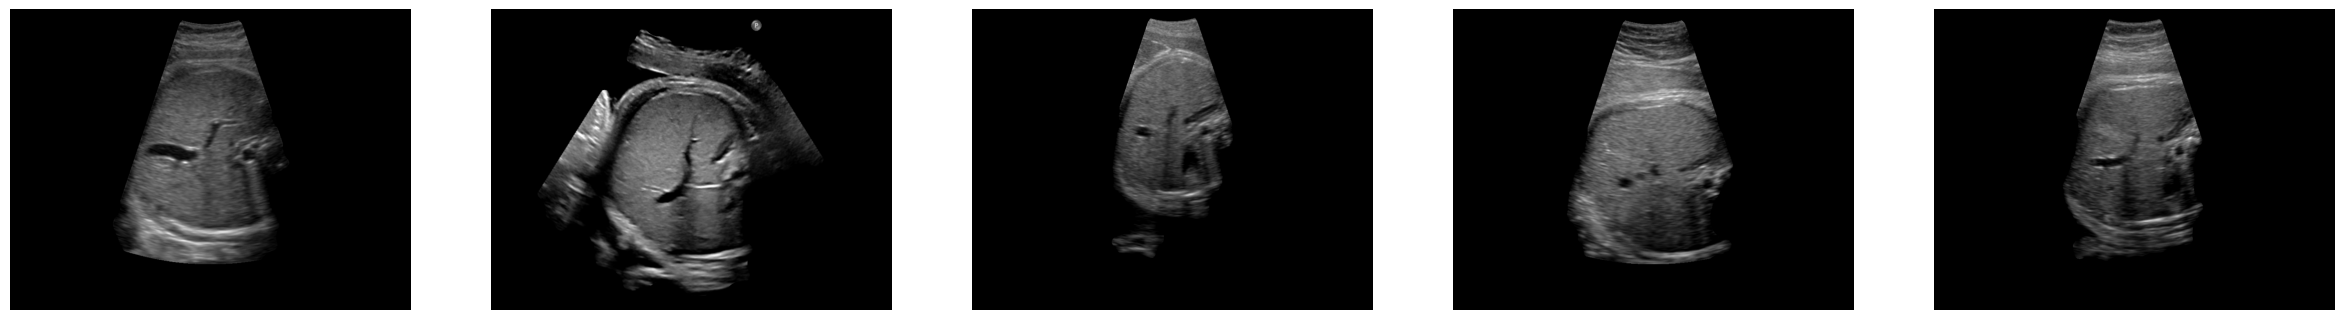

Imagens após reshape:


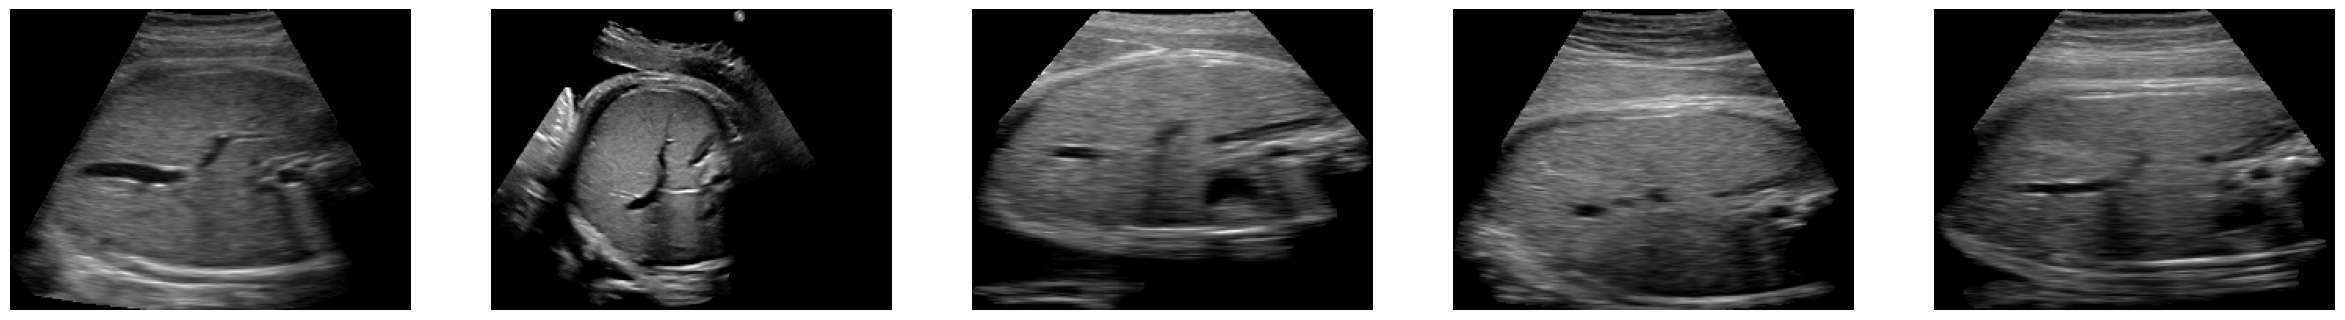

Após transformações:


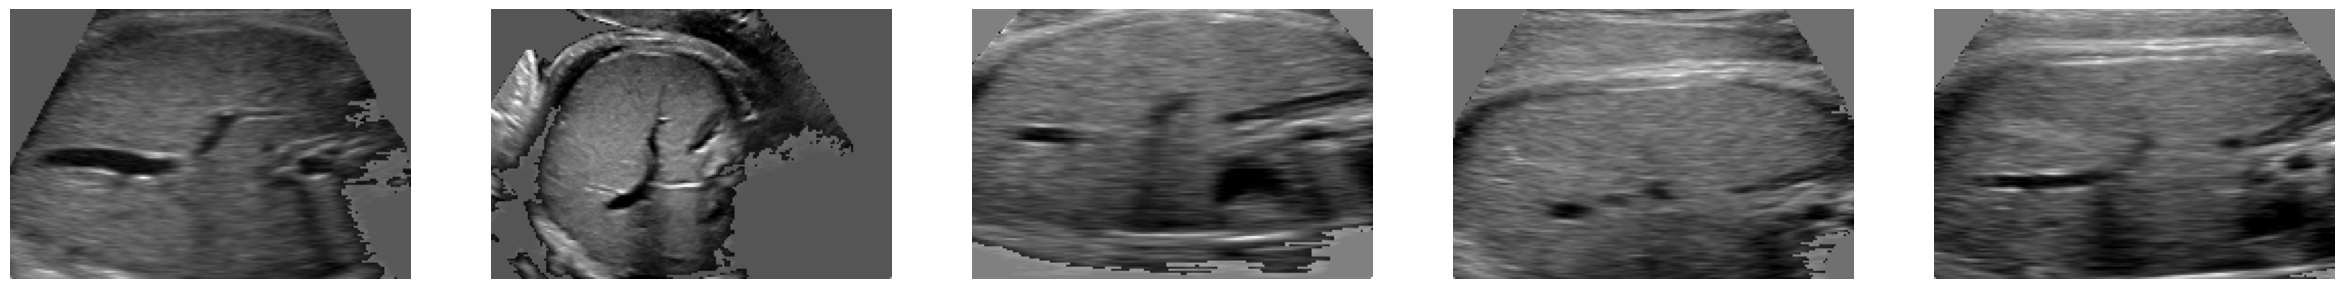

In [22]:
#Passo 1: limpeza 
cleaned_imgs = [(clean(img),stru) for img,stru in data_ex]

plot_images(cleaned_imgs, "Imagens limpas:")

#passo 2: Reshape
scalers = [create_reshape(x) for x,_ in cleaned_imgs]
t_imgs = [(transform(cleaned_imgs[i][0],scalers[i]),cleaned_imgs[i][1]) for i in range(len(cleaned_imgs))]
plot_images(t_imgs ,"Imagens após reshape:")

#passo 3: Transformações
r_imgs = [(reduce(t_imgs[i][0]),t_imgs[i][1]) for i in range(len(t_imgs))]
r_b_imgs = [(remove_black(r_imgs[i][0]),r_imgs[i][1]) for i in range(len(r_imgs))]
plot_images(r_b_imgs,"Após transformações:")


[8, 8, 8, 8, 8]
Predições


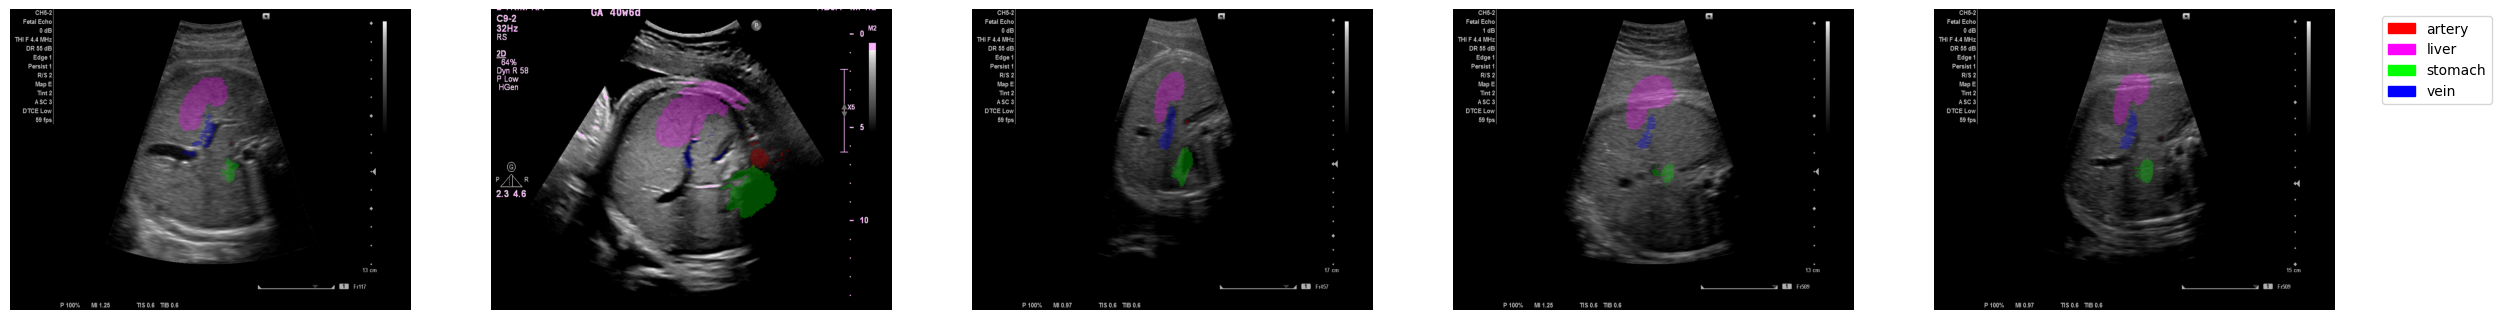

In [5]:
model = Model('MODEL')

predictions = [(data_ex[i][0],model.predict(data_ex[i][0])) for i in range(len(data_ex))]
classes = [model.get_best_class(data_ex[i][0]) for i in range(len(data_ex))]
print(classes)
plot_images(predictions,"Predições",with_labels=True)

In [7]:
model = Model('MODEL')

predictions = [(data_ex[i][0],model.predict(data_ex[i][0])) for i in range(len(data_ex))]
classes = [model.get_best_class(data_ex[i][0]) for i in range(len(data_ex))]
print(classes.count(8))
#plot_images(predictions,"predições",with_labels=True)
#aqui parece que todas as imagens tao sendo mapeadas pra classe 8  PRECISA DE REVISÃO



1000


### Resultados:

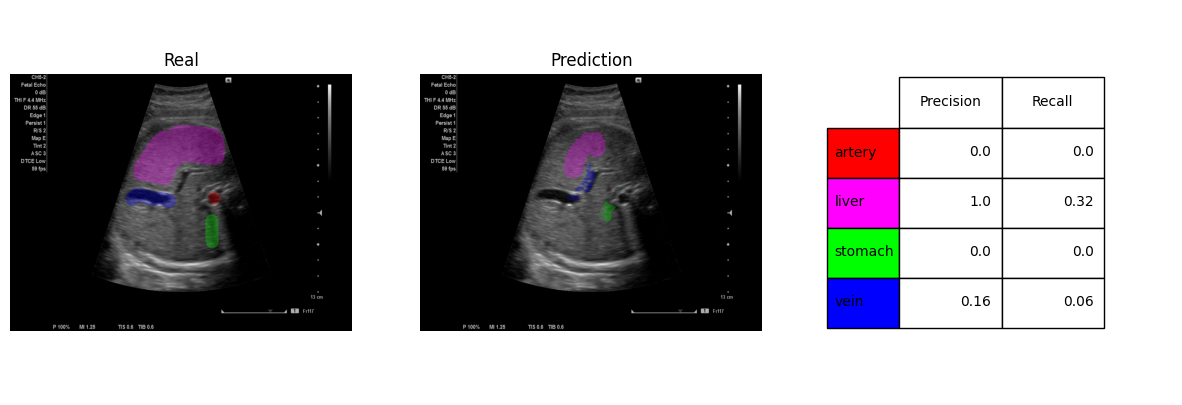

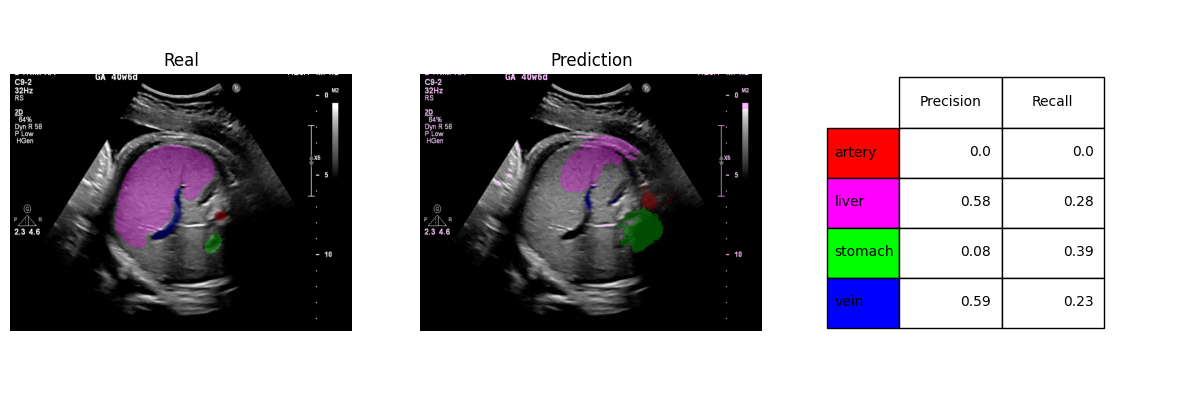

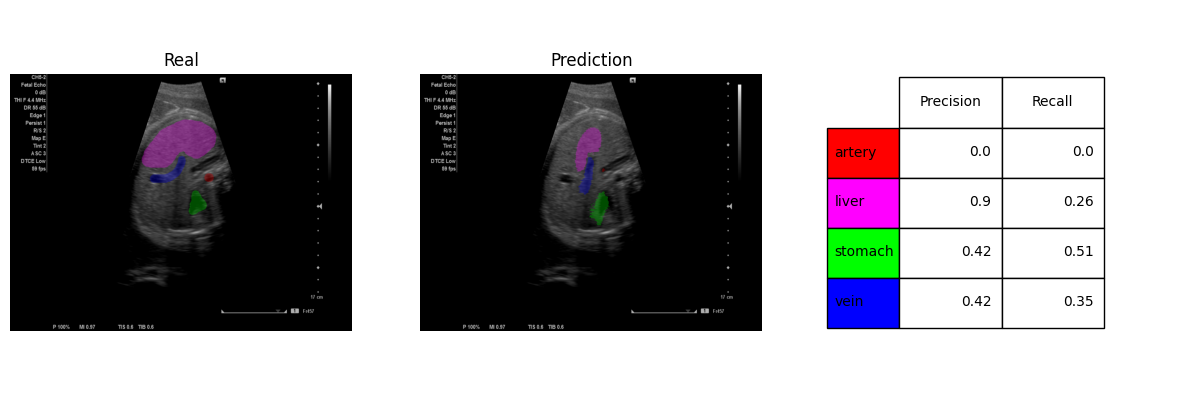

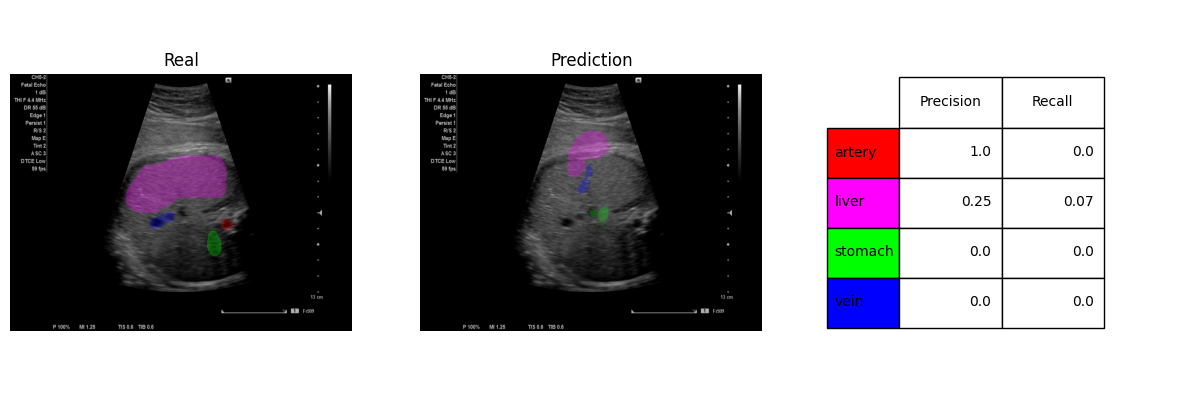

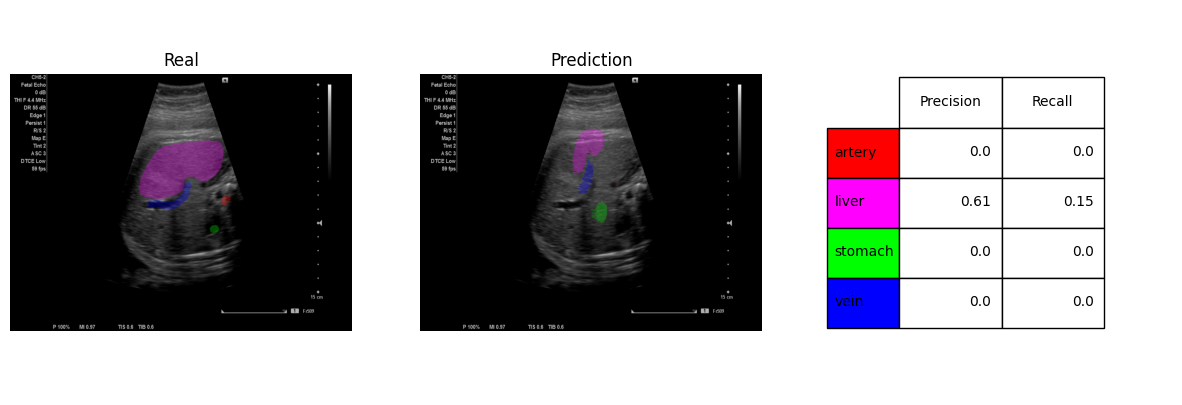

In [20]:
for img,struc in data_ex:

    prediction = model.predict(img)

    plot_pred(img,struc,prediction)

In [6]:
precision = {org:[] for org in ORGAOS}
recall = {org:[] for org in ORGAOS}
conf_matrices_total = {org: np.zeros((2, 2), dtype=int) for org in ORGAOS}  # Supondo binário (2x2)

for i,file in enumerate(data_files[0:20]): #20 fotos
    img,struc = load(file)
    prediction = model.predict(img)
    res = evaluate(struc,prediction)
    conf_mat = conf_matrix(struc,prediction)
    for org in ORGAOS:
        precision[org].append(res[org][0])
        recall[org].append(res[org][1])
        conf_matrices_total[org] += conf_mat[org] 
    print('Files:',i+1,end = '\r')

m_precision = {org:np.array(precision[org]).mean() for org in ORGAOS}
m_recall = {org:np.array(recall[org]).mean() for org in ORGAOS}

table = pd.DataFrame({'Precision':m_precision.values(),'Recall':m_recall.values()},index = ORGAOS)
table



,Precision,Recall
artery,0.381733,0.072973
liver,0.591939,0.298453
stomach,0.188783,0.376655
vein,0.266089,0.347529


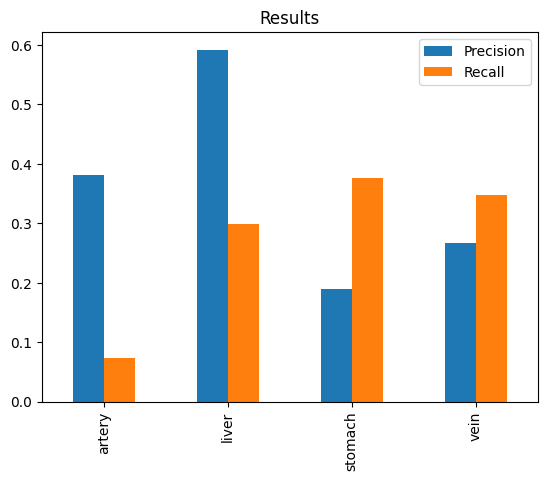

In [16]:
table.plot(kind = 'bar',title = 'Results')
plt.show()

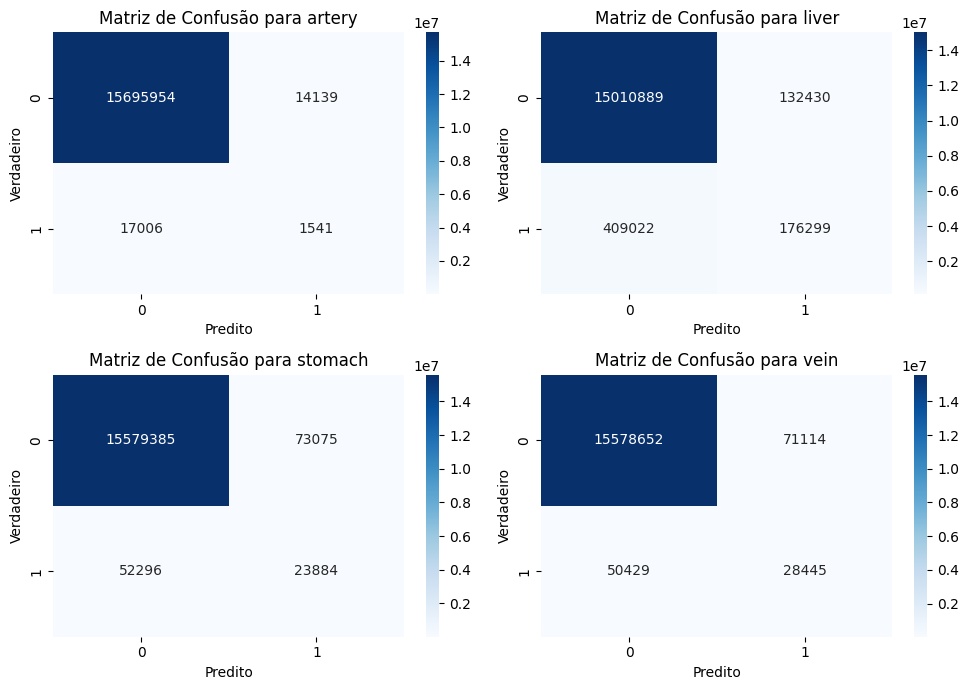

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()  # Para facilitar a iteração


for i, org in enumerate(ORGAOS):
    sns.heatmap(conf_matrices_total[org], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Matriz de Confusão para {org}')
    axes[i].set_xlabel('Predito')
    axes[i].set_ylabel('Verdadeiro')



plt.tight_layout()
plt.show()